# Optimising Gunshot detection model with `opensoundscape`

The versioning of the old project renders its use impractical today. `opensoundscape (v0.5.0)` is at the heart of the previous pipeline. However, using this version today is incompatible with other libaries such as `torch`, whose changes removed elements that made it compatible with the previous pipeline. Instead of recreating an old versioning for this model, I chose to recreate the pipeline with current libraries. This should allow for state-of-the-art edits to further improve the model, and pursue projects in line with my distillation project. 

## Environment setup

### Package Imports

In [10]:
# Machine Learning imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18, efficientnet_b3

# Opensoundscape imports
from opensoundscape import AudioFileDataset, SpectrogramPreprocessor
from opensoundscape.ml.utils import collate_audio_samples_to_tensors
from opensoundscape import data_selection

# Processing imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Import the functions we designed to be used accross notebooks to avoid redundancies between notebooks
from utils.common import list_files, create_dataframe, train_model, evaluate_model

### Global Variables

In [2]:
# Feel free to change the following in order to accommodate your environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mode = "training" if str(device) == "cuda" else "development" 
print(f"Notebook in {mode} mode")

MODEL_DIR = "models/opensoundscape"
TRAIN_PREFIX = "/home/sagemaker-user/Data/Training data" # Adapt this to your environment
VAL_PREFIX   = "/home/sagemaker-user/Data/Validation data"

Notebook in training mode


### Training Parameters
More about choosing a batch size for ResNet [here](https://nikita.melkozerov.dev/posts/transfer-learning-batch-size-experiment/). We put ourselves in similar conditions as in the original paper to be able to compare both models.

In [3]:
batch_size = 128
num_workers = 8 if str(device) == "cuda" else 2
num_epochs = 20
lr = 0.001

## Data Loading

In [4]:
train_keys = list_files(TRAIN_PREFIX)
val_keys   = list_files(VAL_PREFIX)

train_df   = create_dataframe(train_keys)
val_df     = create_dataframe(val_keys)

# We also upsample the minority class
train_df_upsampled = data_selection.upsample(train_df, label_column="label")

print(f"Found {len(train_keys)} training audios, {len(val_keys)} validation audios.")
print(f"Upsampled dataset has {len(train_df_upsampled)} training audios.")

Found 28790 training audios, 7190 validation audios.
Upsampled dataset has 56386 training audios.


Initializing the Audio dataset and the preprocessor using `opensoundscape`. 

Here, we copy out the preprocessing that was done in the original paper, which can be found [here](https://github.com/lydiakatsis/tropical_forest_gunshot_classifier/blob/main/Model%20and%20code/train_GUNSHOT_classifier.py)

In [5]:
train_preprocessor = SpectrogramPreprocessor(sample_duration=4.00)
train_preprocessor.pipeline.random_affine.set(translate=(0.1, 0.05))
train_preprocessor.pipeline.load_audio.set(sample_rate=8000)
train_preprocessor.pipeline.frequency_mask.set(max_width=0.05, max_masks=10)
train_preprocessor.pipeline.time_mask.set(max_width=0.05, max_masks=10)
train_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
train_preprocessor.pipeline.to_spec.set(window_samples=256,overlap_samples=256//2)

val_preprocessor = SpectrogramPreprocessor(sample_duration=4.00)
val_preprocessor.pipeline.load_audio.set(sample_rate=8000)
val_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
val_preprocessor.pipeline.to_spec.set(window_samples=256,overlap_samples=256//2)

train_audio_dataset = AudioFileDataset(train_df_upsampled,train_preprocessor)

val_audio_dataset = AudioFileDataset(val_df,val_preprocessor)
val_audio_dataset.bypass_augmentations = True

In [6]:
train_loader = DataLoader(
    train_audio_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_audio_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

## Plotting a few examples

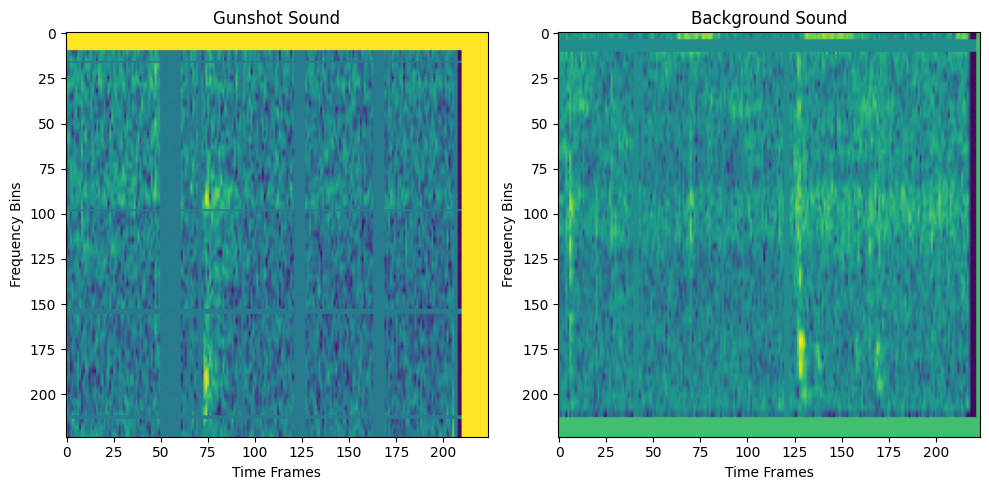

In [25]:
np.random.seed(4) # For reproducibility of results
train_counts = train_df["label"].value_counts().to_dict()
pos_index, neg_index = -np.random.randint(0,train_counts[1]), np.random.randint(0,train_counts[0])

dataset = train_audio_dataset
tensors = [dataset[pos_index].data.squeeze(0), dataset[neg_index].data.squeeze(0)]
sample_titles = ["Gunshot Sound", "Background Sound"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, tensor, title in zip(axes, tensors, sample_titles):
    ax.imshow(tensor, cmap="viridis", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Time Frames")
    ax.set_ylabel("Frequency Bins")
plt.tight_layout()
plt.show()

## Training and evaluating our classifier

ResNet18 is well-suited for gunshot detection with spectrograms because its architecture captures hierarchical audio features while its residual connections mitigate vanishing gradients. We also change the initial kernel size to 5 in order to accommodate for the fact that gunshot are sudden.

In [8]:
ResNet18 = resnet18(weights="IMAGENET1K_V1")
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
ResNet18.fc = nn.Linear(ResNet18.fc.in_features, 2)
ResNet18 = ResNet18.to(device)

output_path_resnet = os.path.join(MODEL_DIR, "best_opensoundscape.pth")
output_path_resnet2 = os.path.join(MODEL_DIR, "last_opensoundscape.pth")

In [ ]:
if mode == "training":
    train_model(ResNet18, train_loader, val_loader, output_path_resnet, output_path_resnet2, num_epochs, lr)

In [7]:
if mode == "training":
    evaluate_model("models/opensoundscape/best_opensoundscape.pth", val_loader, optimized_f1=True)

Evaluating: 100%|██████████| 57/57 [00:35<00:00,  1.59it/s]



=== Classification Report ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00      7040
     Gunshot       0.89      0.87      0.88       150

    accuracy                           1.00      7190
   macro avg       0.94      0.94      0.94      7190
weighted avg       1.00      1.00      1.00      7190


=== Performance Metrics ===
Accuracy: 0.9951
Precision: 0.8912
Recall: 0.8733
F1 Score: 0.8822

=== Performance Metrics - Optimised Threshold ===
Threshold: 0.8983
Precision: 0.9412
Recall: 0.8533
F1 Score: 0.8951

✅ Evaluation complete. Results saved in: evaluation/Run_20250312-0951


## Mel Spectrogram Pipeline

After all experimentations, we can proceed to build the most optimised that achieves the best results yet.

In [5]:
train_preprocessor = SpectrogramPreprocessor(sample_duration=4.00)
train_preprocessor.pipeline.random_affine.set(translate=(0.1, 0.05))
train_preprocessor.pipeline.load_audio.set(sample_rate=8000)
train_preprocessor.pipeline.frequency_mask.set(max_width=0.05, max_masks=15)
train_preprocessor.pipeline.time_mask.set(max_width=0.05, max_masks=15)
train_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
train_preprocessor.pipeline.to_spec = Action(MelSpectrogram.from_audio)
train_preprocessor.pipeline.to_spec.set(window_samples=256, overlap_samples=128)

val_preprocessor = SpectrogramPreprocessor(sample_duration=4.00)
val_preprocessor.pipeline.load_audio.set(sample_rate=8000)
val_preprocessor.pipeline.bandpass.set(min_f=0,max_f=2000)
val_preprocessor.pipeline.to_spec = Action(MelSpectrogram.from_audio)
val_preprocessor.pipeline.to_spec.set(window_samples=256, overlap_samples=128)

train_audio_dataset = AudioFileDataset(train_df_upsampled,train_preprocessor)

val_audio_dataset = AudioFileDataset(val_df,val_preprocessor)
val_audio_dataset.bypass_augmentations = True

In [6]:
train_preprocessor.pipeline.to_spec

Action calling <bound method Spectrogram.from_audio of <class 'opensoundscape.spectrogram.Spectrogram'>>, with .params: 
window_type              hann
window_samples            256
window_length_sec        None
overlap_samples           128
overlap_fraction         None
fft_size                 None
dB_scale                 True
scaling              spectrum
dtype: object

In [7]:
train_loader = DataLoader(
    train_audio_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_audio_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn = collate_audio_samples_to_tensors,
    num_workers=num_workers,
    pin_memory=True
)

## Plotting a few examples

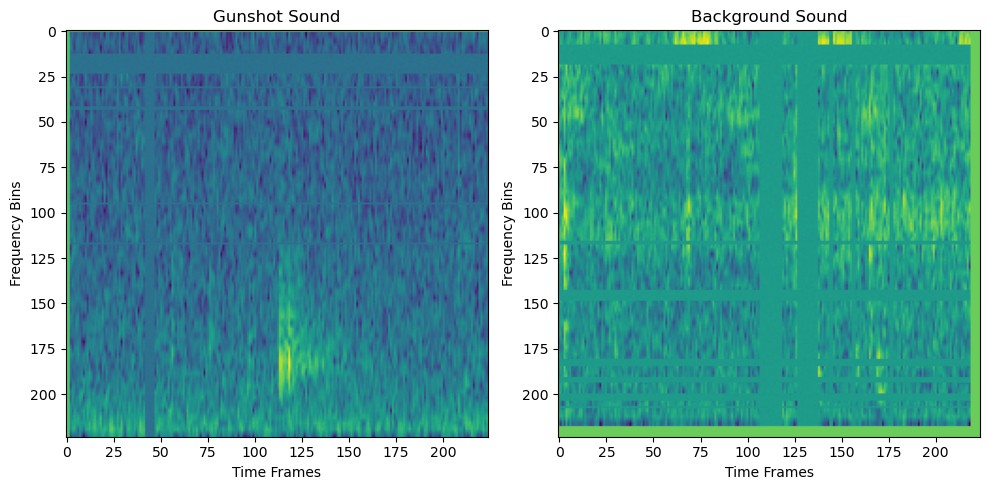

In [8]:
np.random.seed(4) # For reproducibility of results
train_counts = train_df["label"].value_counts().to_dict()
pos_index, neg_index = -np.random.randint(0,train_counts[1]), np.random.randint(0,train_counts[0])

dataset = train_audio_dataset
tensors = [dataset[pos_index].data.squeeze(0), dataset[neg_index].data.squeeze(0)]
sample_titles = ["Gunshot Sound", "Background Sound"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, tensor, title in zip(axes, tensors, sample_titles):
    ax.imshow(tensor, cmap="viridis", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Time Frames")
    ax.set_ylabel("Frequency Bins")
plt.tight_layout()
plt.show()

## Training and evaluating our classifier

EfficientNetB3 is well-suited for gunshot detection with spectrograms because its architecture captures hierarchical audio features while its residual connections mitigate vanishing gradients. We also change the initial kernel size to 5 in order to accommodate for the fact that gunshot are sudden.

In [11]:
EfficientNetB3 = efficientnet_b3(weights="IMAGENET1K_V1")
EfficientNetB3.features[0][0] = nn.Conv2d(1, 40, kernel_size=3, stride=2, padding=1, bias=False)
EfficientNetB3.classifier[1] = nn.Linear(EfficientNetB3.classifier[1].in_features, 2)
EfficientNetB3 = EfficientNetB3.to(device)

output_path_resnet = os.path.join(MODEL_DIR, "best_opensoundscape2.pth")
output_path_resnet2 = os.path.join(MODEL_DIR, "last_opensoundscape2.pth")

In [ ]:
if mode == "training":
    train_model(EfficientNetB3, train_loader, val_loader, output_path_resnet, output_path_resnet2, num_epochs, lr)


🚀 Starting Epoch [1/40]


Epoch 1/40 [Validation]: 100%|██████████| 57/57 [00:40<00:00,  1.40it/s]


📊 Epoch [1/40] | Train Loss: 0.0767 | Val Loss: 0.0614 | F1 Score: 0.6821
✅ New Best Model Found! Saving at models/best_final.pth

🚀 Starting Epoch [2/40]


Epoch 2/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.66it/s]


📊 Epoch [2/40] | Train Loss: 0.0269 | Val Loss: 0.0600 | F1 Score: 0.7165
✅ New Best Model Found! Saving at models/best_final.pth

🚀 Starting Epoch [3/40]


Epoch 3/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.52it/s]


📊 Epoch [3/40] | Train Loss: 0.0190 | Val Loss: 0.0394 | F1 Score: 0.8371
✅ New Best Model Found! Saving at models/best_final.pth

🚀 Starting Epoch [4/40]


Epoch 4/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.58it/s]


📊 Epoch [4/40] | Train Loss: 0.0164 | Val Loss: 0.0303 | F1 Score: 0.8045

🚀 Starting Epoch [5/40]


Epoch 5/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.70it/s]


📊 Epoch [5/40] | Train Loss: 0.0141 | Val Loss: 0.0600 | F1 Score: 0.7616

🚀 Starting Epoch [6/40]


Epoch 6/40 [Validation]: 100%|██████████| 57/57 [00:06<00:00,  9.44it/s]


📊 Epoch [6/40] | Train Loss: 0.0113 | Val Loss: 0.0435 | F1 Score: 0.7900

🚀 Starting Epoch [7/40]


Epoch 7/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.71it/s]


📊 Epoch [7/40] | Train Loss: 0.0107 | Val Loss: 0.0554 | F1 Score: 0.7794

🚀 Starting Epoch [8/40]


Epoch 8/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.74it/s]


📊 Epoch [8/40] | Train Loss: 0.0123 | Val Loss: 0.0650 | F1 Score: 0.7189

🚀 Starting Epoch [9/40]


Epoch 9/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.73it/s]


📊 Epoch [9/40] | Train Loss: 0.0095 | Val Loss: 0.0664 | F1 Score: 0.7515

🚀 Starting Epoch [10/40]


Epoch 10/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.61it/s]


📊 Epoch [10/40] | Train Loss: 0.0042 | Val Loss: 0.0681 | F1 Score: 0.8077

🚀 Starting Epoch [11/40]


Epoch 11/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.50it/s]


📊 Epoch [11/40] | Train Loss: 0.0035 | Val Loss: 0.0759 | F1 Score: 0.8025

🚀 Starting Epoch [12/40]


Epoch 12/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.63it/s]


📊 Epoch [12/40] | Train Loss: 0.0026 | Val Loss: 0.0766 | F1 Score: 0.8278

🚀 Starting Epoch [13/40]


Epoch 13/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.81it/s]


📊 Epoch [13/40] | Train Loss: 0.0025 | Val Loss: 0.0833 | F1 Score: 0.8350

🚀 Starting Epoch [14/40]


Epoch 14/40 [Validation]: 100%|██████████| 57/57 [00:07<00:00,  7.23it/s]


📊 Epoch [14/40] | Train Loss: 0.0015 | Val Loss: 0.0835 | F1 Score: 0.8367

🚀 Starting Epoch [15/40]


Epoch 15/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.55it/s]


📊 Epoch [15/40] | Train Loss: 0.0019 | Val Loss: 0.0727 | F1 Score: 0.8754
✅ New Best Model Found! Saving at models/best_final.pth

🚀 Starting Epoch [16/40]


Epoch 16/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.64it/s]


📊 Epoch [16/40] | Train Loss: 0.0017 | Val Loss: 0.0899 | F1 Score: 0.8512

🚀 Starting Epoch [17/40]


Epoch 17/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.56it/s]


📊 Epoch [17/40] | Train Loss: 0.0014 | Val Loss: 0.0801 | F1 Score: 0.8522

🚀 Starting Epoch [18/40]


Epoch 18/40 [Validation]: 100%|██████████| 57/57 [00:05<00:00,  9.65it/s]


📊 Epoch [18/40] | Train Loss: 0.0011 | Val Loss: 0.1015 | F1 Score: 0.8451

🚀 Starting Epoch [19/40]


Epoch 19/40 [Training]:  20%|██        | 89/441 [00:31<01:59,  2.95it/s]

In [ ]:
if mode == "training":
    evaluate_model(output_path_resnet, val_loader, optimized_f1=True)